## 1. 필요한 라이브러리 import

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.io

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms, models
from torch.cuda.amp import GradScaler, autocast

from tqdm import tqdm

## 2. GPU & 하이퍼 파라미터 설정

In [ ]:
# GPU 설정
device = (
    "mps" if torch.backends.mps.is_available()
    else "cuda" if torch.cuda.is_available()
    else "cpu"
)
print(f"Using device: {device}")

if device == "mps":
    device = torch.device("mps")
elif device == "cuda":
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# AMP 사용 설정
use_amp = device.type == 'cuda'  # CUDA에서만 AMP 사용
print(f"Using Automatic Mixed Precision: {use_amp}")

# 배치 사이즈 설정
if device.type == 'cuda':
    batch_size = 16
elif device.type == 'mps':
    batch_size = 8
else:
    batch_size = 4

# Worker 수 설정
num_workers = 4 if device.type == 'cuda' else 0

# Pin memory 설정
pin_memory = device.type == 'cuda'

Using device: mps
Using Automatic Mixed Precision: False


## 3. Pretrained Model Load

In [ ]:
# 사전 훈련된 ResNet50 로드
resnet = models.resnet50(pretrained=True)

/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/homebrew/Caskroom/miniforge/base/envs/cv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## 4. DeepLabV3Plus Model Define

In [ ]:
class DeepLabV3Plus(nn.Module):
    def __init__(self, n_classes, output_stride=16):
        """DeepLabV3+ 모델 초기화
        Args:
            n_classes (int): 분류할 클래스 수
            output_stride (int): 출력 feature map의 다운샘플링 비율 (8 or 16)
        """
        super(DeepLabV3Plus, self).__init__()

        # ResNet50 백본 모델 로드 및 초기화
        backbone = models.resnet50(pretrained=True)

        # 초기 레이어 설정 (입력 이미지를 1/4 크기로 축소)
        self.initial_layers = nn.Sequential(
            backbone.conv1,    # 7x7 conv, stride=2
            backbone.bn1,      # batch normalization
            backbone.relu,     # ReLU activation
            backbone.maxpool   # 3x3 maxpool, stride=2
        )

        # Regular ResNet 블록 (dilation 없음)
        self.layer1 = backbone.layer1  # output: 1/4
        self.layer2 = backbone.layer2  # output: 1/8

        # Dilated ResNet 블록 (공간 해상도 유지를 위해 dilation 적용)
        if output_stride == 16:
            self.layer3 = self._make_dilated_layer(backbone.layer3, dilation=2)  # output: 1/16
            self.layer4 = self._make_dilated_layer(backbone.layer4, dilation=4)  # output: 1/16
        elif output_stride == 8:
            self.layer3 = self._make_dilated_layer(backbone.layer3, dilation=4)  # output: 1/8
            self.layer4 = self._make_dilated_layer(backbone.layer4, dilation=8)  # output: 1/8

        # ASPP 모듈 (multi-scale context 캡처)
        self.aspp = ASPP(in_channels=2048, out_channels=256, output_stride=output_stride)

        # Decoder 모듈
        self.decoder = Decoder(num_classes=n_classes, low_level_channels=48)

        # Low-level feature 처리 (채널 수 감소)
        self.low_level_conv = nn.Sequential(
            nn.Conv2d(512, 48, 1, bias=False),  # 512 -> 48 channels
            nn.BatchNorm2d(48),
            nn.ReLU()
        )

    def _make_dilated_layer(self, layer, dilation):
        """ResNet 블록의 3x3 컨볼루션에 dilation 적용
        Args:
            layer: ResNet 블록
            dilation (int): dilation rate
        Returns:
            수정된 layer
        """
        for m in layer.modules():
            if isinstance(m, nn.Conv2d):
                if m.kernel_size == (3, 3):
                    m.dilation = (dilation, dilation)
                    m.padding = (dilation, dilation)
        return layer

    def forward(self, x):
        """Forward pass
        Args:
            x: 입력 이미지 텐서, shape: [B, 3, H, W]
        Returns:
            출력 텐서, shape: [B, n_classes, H, W]
        """
        input_size = x.size()[2:]  # 원본 이미지 크기 저장

        # Encoder path
        x = self.initial_layers(x)         # 1/4
        x = self.layer1(x)                 # 1/4
        low_level_feat = self.layer2(x)    # 1/8
        x = self.layer3(low_level_feat)    # 1/16 (with dilation)
        x = self.layer4(x)                 # 1/16 (with dilation)

        # ASPP module
        x = self.aspp(x)

        # Low-level feature 처리
        low_level_feat = self.low_level_conv(low_level_feat)

        # Decoder
        x = self.decoder(x, low_level_feat)

        # 원본 이미지 크기로 업샘플링
        x = F.interpolate(x, size=input_size, mode='bilinear', align_corners=True)

        return x

class ASPP(nn.Module):
    """Atrous Spatial Pyramid Pooling 모듈"""
    def __init__(self, in_channels, out_channels, output_stride=16):
        """ASPP 모듈 초기화
        Args:
            in_channels (int): 입력 채널 수
            out_channels (int): 출력 채널 수
            output_stride (int): backbone의 output stride
        """
        super(ASPP, self).__init__()

        # Output stride에 따른 dilation rate 설정
        if output_stride == 16:
            dilations = [1, 6, 12, 18]
        elif output_stride == 8:
            dilations = [1, 12, 24, 36]

        # 1x1 convolution (rate=1)
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        # 다양한 dilation rate를 가진 3x3 convolutions
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,
                     padding=dilations[1], dilation=dilations[1], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,
                     padding=dilations[2], dilation=dilations[2], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3,
                     padding=dilations[3], dilation=dilations[3], bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU()
        )

        # Global context 정보를 위한 global average pooling
        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.global_conv = nn.Conv2d(in_channels, out_channels, 1, bias=False)

        # 최종 1x1 convolution으로 feature 융합
        self.project = nn.Sequential(
            nn.Conv2d(out_channels * 5, out_channels, 1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
            nn.Dropout(0.5)
        )

    def forward(self, x):
        """Forward pass
        Args:
            x: 입력 feature map
        Returns:
            처리된 feature map
        """
        size = x.size()[2:]

        # 다양한 rate로 feature 추출
        feat1 = self.conv1(x)        # rate=1
        feat2 = self.conv2(x)        # rate=6/12
        feat3 = self.conv3(x)        # rate=12/24
        feat4 = self.conv4(x)        # rate=18/36

        # Global context
        feat5 = self.global_avg_pool(x)
        feat5 = self.global_conv(feat5)
        feat5 = F.interpolate(feat5, size=size, mode='bilinear', align_corners=True)

        # Feature 융합
        x = torch.cat((feat1, feat2, feat3, feat4, feat5), dim=1)
        x = self.project(x)

        return x

class Decoder(nn.Module):
    """DeepLabV3+ Decoder 모듈"""
    def __init__(self, num_classes, low_level_channels):
        """Decoder 초기화
        Args:
            num_classes (int): 분류할 클래스 수
            low_level_channels (int): low-level feature의 채널 수
        """
        super(Decoder, self).__init__()

        # Refinement를 위한 convolution 블록
        self.fuse_conv = nn.Sequential(
            nn.Conv2d(low_level_channels + 256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )

        # 최종 분류를 위한 1x1 convolution
        self.classifier = nn.Conv2d(256, num_classes, 1)

    def forward(self, x, low_level_feat):
        """Forward pass
        Args:
            x: ASPP의 출력 feature map
            low_level_feat: encoder의 low-level feature
        Returns:
            분류 결과
        """
        # ASPP 출력을 low-level feature 크기로 업샘플링
        x = F.interpolate(x, size=low_level_feat.size()[2:],
                         mode='bilinear', align_corners=True)

        # Low-level feature와 결합
        x = torch.cat([x, low_level_feat], dim=1)

        # 최종 처리
        x = self.fuse_conv(x)
        x = self.classifier(x)

        return x

### Model Output Check

In [ ]:
# Output stride 16 사용
model_DeepLabV3Plus_16 = DeepLabV3Plus(n_classes=21, output_stride=16)

x = torch.randn(1, 3, 512, 512)  # 8의 배수 크기
output = model_DeepLabV3Plus_16(x)  # Shape: [1, 21, 512, 512]
print(output.shape)

torch.Size([1, 21, 512, 512])


In [ ]:
# Output stride 8 사용 (더 높은 해상도, 더 많은 메모리 사용)
model_DeepLabV3Plus_8 = DeepLabV3Plus(n_classes=21, output_stride=8)
print(output.shape)

torch.Size([1, 21, 512, 512])


## 5. Dataset Define

In [ ]:
# Dataset 클래스 정의
class CIHPDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, target_transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.target_transform = target_transform

        self.image_list = sorted(os.listdir(self.image_dir))
        self.mask_list = sorted(os.listdir(self.mask_dir))

    def __len__(self):
        return len(self.image_list)

    def __getitem__(self, idx):
        # 이미지 및 마스크 경로
        img_path = os.path.join(self.image_dir, self.image_list[idx])
        mask_path = os.path.join(self.mask_dir, self.mask_list[idx])

        # 이미지 및 마스크 로드
        image = Image.open(img_path).convert('RGB')
        mask = Image.open(mask_path)

        # Transform 적용
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)
        else:
            mask = torch.from_numpy(np.array(mask, dtype=np.int64))

        return image, mask

### Data Download

In [ ]:
# 데이터 다운로드 및 체크 함수
def check_and_download_dataset():
    data_dir = './instance-level_human_parsing'
    zip_path = 'instance-level_human_parsing.zip'

    if os.path.exists(data_dir):
        print("Dataset already exists. Skipping download.")
        return True

    print("Dataset not found. Downloading...")
    try:
        import gdown
        file_id = '1B9A9UCJYMwTL4oBEo4RZfbMZMaZhKJaz'
        gdown.download(id=file_id, output=zip_path, quiet=False)

        file_size = os.path.getsize(zip_path)
        print(f"Downloaded file size: {file_size} bytes")

        os.system('7z x instance-level_human_parsing.zip')
        os.remove(zip_path)
        return True
    except Exception as e:
        print(f"Error during download/extraction: {e}")
        return False

# 데이터 경로 설정
data_dir = './instance-level_human_parsing/instance-level_human_parsing/Training'
image_dir = os.path.join(data_dir, 'Images')
mask_dir = os.path.join(data_dir, 'Category_ids')
colormap_path = './instance-level_human_parsing/instance-level_human_parsing/human_colormap.mat'

# 데이터셋 준비
if not check_and_download_dataset():
    raise Exception("Failed to prepare dataset")

Dataset already exists. Skipping download.


### Data preprocessing

In [ ]:
# 이미지 변환 정의
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [ ]:
# 마스크 변환 함수
def mask_transform(mask):
    mask = mask.resize((512, 512), resample=Image.NEAREST)
    mask = np.array(mask, dtype=np.int64)
    return torch.from_numpy(mask)

In [ ]:
# 데이터셋 생성
dataset = CIHPDataset(
    image_dir=image_dir,
    mask_dir=mask_dir,
    transform=image_transform,
    target_transform=mask_transform
)

In [ ]:
# 데이터셋 분할 (8:2)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(
    dataset,
    [train_size, val_size],
    generator=torch.Generator().manual_seed(42)
)

## 6. DataLoader & Loss Function & Optimaizer Define

In [ ]:
# DataLoader 생성
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    num_workers=num_workers,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=False,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [ ]:
# 모델 초기화 및 디바이스로 이동
model = DeepLabV3Plus(n_classes=21, output_stride=16).to(device)

# Loss function과 optimizer 설정
criterion = nn.CrossEntropyLoss(ignore_index=255)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
scaler = GradScaler() if use_amp else None

## 7. Model Train

- T4 기준 Epoch 2 -> 52 min
- M3Max CPU 기준 Epoch 1 -> 6 Hour
- M3Max MPS 기준 Epoch 2 -> 40 min

In [ ]:
# 학습 루프
num_epochs = 2
best_val_loss = float('inf')

for epoch in range(num_epochs):
    # Training
    model.train()
    running_loss = 0.0
    train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")

    for images, masks in train_loader_tqdm:
        images = images.to(device)
        masks = masks.to(device)

        optimizer.zero_grad()

        if use_amp:
            with autocast():
                outputs = model(images)
                outputs = F.interpolate(outputs, size=(512, 512),
                                     mode='bilinear', align_corners=False)
                loss = criterion(outputs, masks)

            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            outputs = model(images)
            outputs = F.interpolate(outputs, size=(512, 512),
                                  mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

        running_loss += loss.item()
        train_loader_tqdm.set_postfix(loss=loss.item())

        # MPS 메모리 정리
        if device.type == 'mps':
            torch.mps.empty_cache()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

    # Validation
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for images, masks in val_loader:
            images = images.to(device)
            masks = masks.to(device)
            outputs = model(images)
            outputs = F.interpolate(outputs, size=(512, 512),
                                  mode='bilinear', align_corners=False)
            loss = criterion(outputs, masks)
            val_loss += loss.item()

            if device.type == 'mps':
                torch.mps.empty_cache()

    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # 모델 저장
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': val_loss,
        }, 'best_model.pth')


Epoch 1/2: 100%|██████████| 2828/2828 [18:16<00:00,  2.58batch/s, loss=0.438]


Epoch [1/2], Loss: 0.5974
Validation Loss: 0.4595


Epoch 2/2: 100%|██████████| 2828/2828 [18:09<00:00,  2.60batch/s, loss=0.434]


Epoch [2/2], Loss: 0.4338
Validation Loss: 0.4350


## 8. Visualization

In [ ]:
# 결과 시각화
colormap = scipy.io.loadmat(colormap_path)['colormap']
colormap = (colormap * 255).astype(np.uint8)

def decode_segmap(label_mask, colormap):
    label_mask = label_mask.numpy()
    h, w = label_mask.shape
    output = np.zeros((h, w, 3), dtype=np.uint8)
    for label in np.unique(label_mask):
        if label == 255:
            continue
        output[label_mask == label] = colormap[label]
    return output

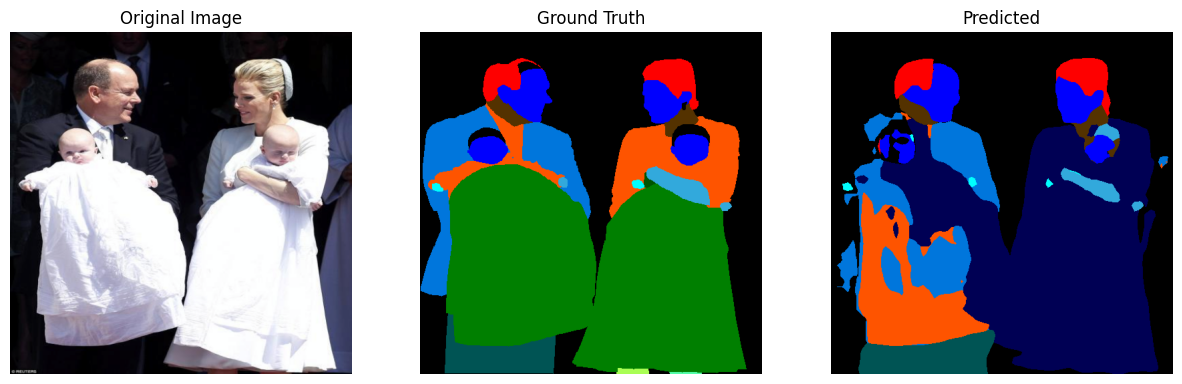

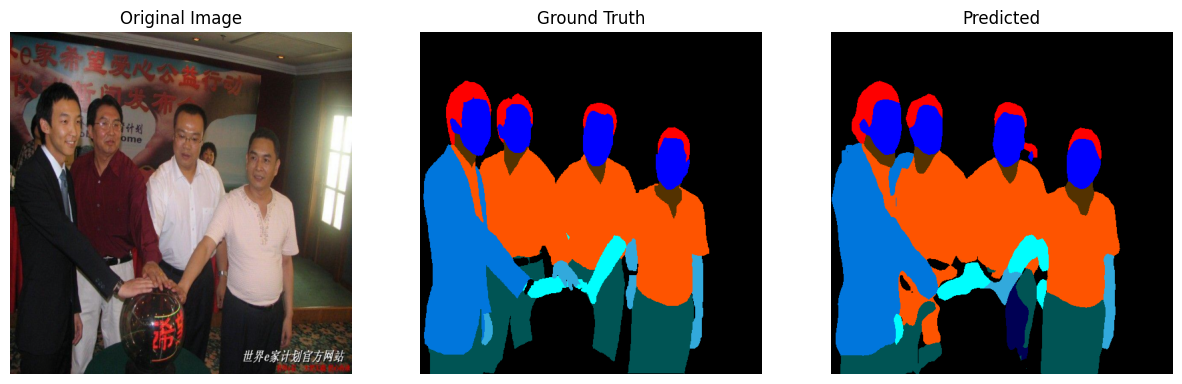

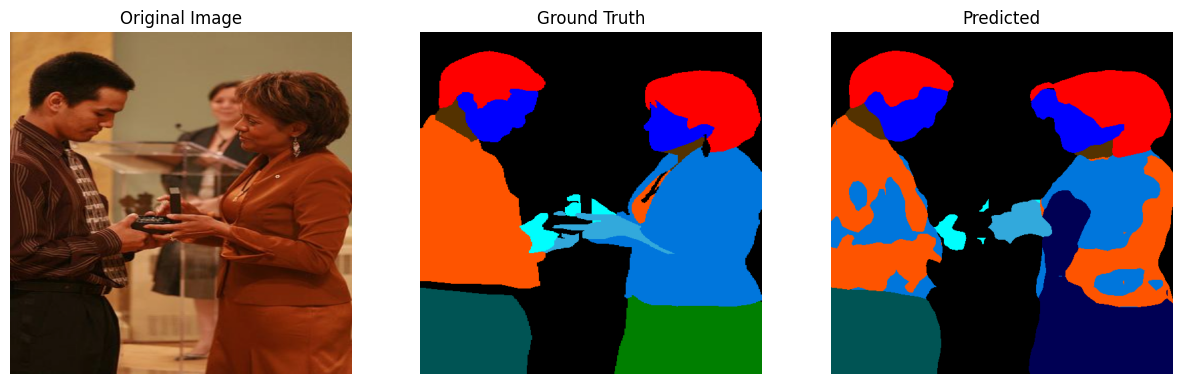

In [ ]:
# 시각화
model.eval()
with torch.no_grad():
    for idx in range(3):  # 샘플 3개만 시각화
        image, mask = val_dataset[idx]
        image_input = image.unsqueeze(0).to(device)
        output = model(image_input)
        pred = torch.argmax(output, dim=1).squeeze(0).cpu()

        # 원본 이미지 변환
        orig_image = image.permute(1, 2, 0).cpu().numpy()
        orig_image = (orig_image * np.array([0.229, 0.224, 0.225]) +
                     np.array([0.485, 0.456, 0.406]))
        orig_image = np.clip(orig_image, 0, 1)
        orig_image = (orig_image * 255).astype(np.uint8)

        # 마스크 디코딩
        decoded_mask = decode_segmap(pred, colormap)
        true_mask = decode_segmap(mask, colormap)

        # 결과 표시
        plt.figure(figsize=(15, 5))
        plt.subplot(1, 3, 1)
        plt.imshow(orig_image)
        plt.title('Original Image')
        plt.axis('off')

        plt.subplot(1, 3, 2)
        plt.imshow(true_mask)
        plt.title('Ground Truth')
        plt.axis('off')

        plt.subplot(1, 3, 3)
        plt.imshow(decoded_mask)
        plt.title('Predicted')
        plt.axis('off')

        plt.show()

### Reference

- [DeepLabv3 & DeepLabv3+ The Ultimate PyTorch Guide](https://learnopencv.com/deeplabv3-ultimate-guide/)